In [2]:
from nuscenes.nuscenes import NuScenes
directory = r"/home/kfir/workspace/nuScenes/v1.0-trainval"
nusc = NuScenes(version="v1.0-trainval", dataroot=directory, verbose=False)

In [3]:
%load_ext autoreload
%autoreload 2
from dataset import *
from video import SimulationVideo
from video import NuscenesVideo, NuscenesVideoDebug, PFVideo, PFXYVideo
from MapMatching import MapMatching

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import copy
class Simulation():
    def __init__(self, model, **kwargs):
        pass
    
    def run(self, N):
        pass
    
class DynamicSimulation():
    def __init__(self, model, **kwargs):
        self.model = model
        self.dataset = DynamicSimulatedDataset()
        self.video = SimulationVideo()
    
    def run(self, N):
        for t in range(0,N):
            print(f"frame {t}")
            zw, covw, prior, video_data = self.dataset.getData(t)
            print("prior", prior)
            points, polynoms = self.model.run(zw,covw,prior)
            self.video.save(t, prior, video_data, points, polynoms, self.model.getDebugInfo())
            
class NuscenesSimulation():
    def __init__(self, static_tracker, scene_id=5, **kwargs):
        self.static_tracker = static_tracker
        directory = kwargs.pop('directory', r"/home/kfir/workspace/nuScenes/v1.0-trainval")
        self.mm = kwargs.pop('mm', False)
        self.nmax = kwargs.pop('Nmax', 800)
        self.dataset = NuscenesDataset(nusc=nusc, directory=directory, scene_id=scene_id, N=self.nmax)
        #self.video = NuscenesVideo(history=True, scene=scene)
        #self.video_debug = NuscenesVideoDebug(history=True, scene=scene)
        self.pf_video = PFVideo(history=True, scene=scene, N=self.nmax)
        #self.pf_xy_video = PFXYVideo(history=True, scene=scene, N=self.nmax)
        self.map_matching = MapMatching(N=200)
        self.lane = None
        self.scene = scene
        
    def getBestLane(self, prior):
        if self.lane is None:
                self.lane = prior[0]
                lane = prior[0]
        else:
            for pr in prior:
                if 1:#if np.linalg.norm(self.lane["poly"][1]-pr["poly"][1]) < 2 and np.linalg.norm(self.lane["poly"][0]-pr["poly"][0]) < 0.1:
                    lane = pr
                    self.lane = pr

        lanes = [lane]
        return lanes
    
    def translatePolynom(self, c, xstart, xend, pos):
        x = np.array([xstart, 0.5*(xstart+xend), xend])
        x_trns = x - pos[0]
        y = np.array([c[0]*x[0]**2+c[1]*x[0]+c[2], c[0]*x[1]**2+c[1]*x[1]+c[2], c[0]*x[2]**2+c[1]*x[2]+c[2]])
        y_trns = y - pos[1]
        A = [[x_trns[0]**2, x_trns[0], 1],[x_trns[1]**2, x_trns[1], 1],[x_trns[2]**2, x_trns[2], 1]]
        c = np.linalg.inv(A).dot(y_trns)
        
        return c
    
    def getPriorList(self, prior, translation):            
        #lanes = self.getBestLane(prior)
        lanes = copy.deepcopy(prior)
        lanes = self.translatePrior(translation, lanes)

        prior_list = []
        for lane in lanes:
            (a0,a1,a2) = lane["poly"].c[2], lane["poly"].c[1], lane["poly"].c[0]
            prior_list.append({"c": (a0,a1,a2), "xmin": np.min(lane["x"]), "xmax": np.max(lane["x"])})
            
        return prior_list
        
    def translatePrior(self, pos, prior):
        for pr in prior:
            min_x = np.min(pr["x"])
            max_x = np.max(pr["x"])
            c = self.translatePolynom(pr["poly"].c, min_x, max_x, pos)
            pr["poly"] = np.poly1d(c)
            pr["x"] -= pos[0]
        
        return prior
    
    def translateMeasurements(self, zw, pos):
        return zw - pos
        
    def translateOutput(self, points, polynoms, pos):
        points = points - pos
        for polynom in polynoms:
            c = self.translatePolynom(polynom["f"].c, polynom["x_start"], polynom["x_end"], pos)
            polynom["f"] = np.poly1d(c)
            polynom["x_start"] -= pos[0]
            polynom["x_end"] -= pos[0]
        
        return points, polynoms
    
    def drawPlots(self, t, video_data, polynoms, points, nusc_map, video_with_priors, translation, generate_video=False):
        try:
            self.video.save(t,video_data, polynoms, nusc_map, video_with_priors=video_with_priors)
        except:
            pass
        try:
            self.video_debug.save(t,video_data, polynoms,points, nusc_map, self.static_tracker.getDebugInfo(), video_with_priors=video_with_priors)
        except:
            pass

        if self.mm:
            mm_results = self.map_matching.getResults()
            mm_results["pf_best_pos"] += translation[0:2]
            mm_results["pf_mean_pos"] += translation[0:2]
            print("mm_results[pf_mean_pos]", mm_results["pf_mean_pos"], "IMU pos", video_data["pos_imu"], "GT", video_data["pos"])
            self.pf_video.save(t,video_data, mm_results, polynoms, nusc_map)
            try:
                self.pf_xy_video.save(t,video_data, mm_results, polynoms, nusc_map)
            except:
                pass
        
        if generate_video:
            try:
                self.video.generate(name=f"video\scene{self.scene}.avi", fps=5)
            except:
                pass
            try:
                self.video_debug.generate(name=f"video\scene{self.scene}_debug.avi", fps=5)
            except:
                pass
            try:
                self.pf_video.generate(name=f"video\scene{self.scene}_debug.avi", fps=5)
            except:
                pass
    
    def runStaticTracker(self, zw, covw, prior, video_data, translation):
        #translate measurements and priors relative to the first position [floating point precision reasons]
        zw = self.translateMeasurements(zw, translation)
        prior_list = self.getPriorList(prior, translation)
        #run static tracker
        points, polynoms = self.static_tracker.run(zw,covw,prior_list)
        points, polynoms = self.translateOutput(points, polynoms, -1*translation)
        
        return points, polynoms
        
    def runMapMatching(self, video_data, translation, nusc_map):
        if self.mm:
            extended_tracks = self.static_tracker.getExtendedTracks()
            orig_world_ref = video_data["pos_imu"]
            world_ref = np.array([orig_world_ref[0]-translation[0], orig_world_ref[1]-translation[1]])
            orig_radar_ref = video_data["pos"]
            radar_ref = np.array([video_data["pos"][0]-translation[0], video_data["pos"][1]-translation[1]]) 
            self.map_matching.run(extended_tracks, nusc_map, orig_world_ref, world_ref, orig_radar_ref, radar_ref, video_data["rot_imu"], video_data["heading_imu"], video_data["odometry"])
        
    def run(self,start, N, generate_video=False, video_with_priors=False, debug=False, translate=True):
        start_idx = start
        first = True
        for t in range(start_idx,start_idx + N):
            print(f"frame {t}")
            #get data
            zw, covw, prior, video_data, nusc_map = self.dataset.getData(t)
            translation = np.array(video_data["ego_path"][0])[0:2]
            #run static tracker
            points, polynoms = self.runStaticTracker(zw, covw, prior, video_data, translation)
            #Run map-matching
            self.runMapMatching(video_data, translation, nusc_map)
            #Draw plots
            self.drawPlots(t, video_data, polynoms, points, nusc_map, video_with_priors, translation, generate_video=generate_video)
            

In [ ]:
from tracker import Tracker
static_tracker = Tracker()
#sim = DynamicSimulation(model)
scene = 690 #365
sim = NuscenesSimulation(static_tracker,scene_id=scene, mm=True, Nmax=1200)
sim.run(start=0, N=100, generate_video=False, video_with_priors=True, debug=False)

scene_id=690 scene_name=scene-0904 map_name=boston-seaport
odom_speed [[1.53729795e+15 9.00000000e+00]
 [1.53729795e+15 9.00000000e+00]
 [1.53729795e+15 9.00000000e+00]
 ...
 [1.53729811e+15 3.70000000e+01]
 [1.53729811e+15 3.70000000e+01]
 [1.53729811e+15 3.70000000e+01]]


No handles with labels found to put in legend.
No handles with labels found to put in legend.


frame 0
zw [[1130.0907068  1591.29438363]
 [1126.89531055 1576.51981607]
 [1127.87815148 1573.4160447 ]
 [1133.62304997 1578.18595588]
 [1122.59605847 1565.84163247]
 [1126.70891479 1564.16699333]
 [1134.32463979 1564.16840344]
 [1140.90029636 1564.76835083]
 [1141.34183997 1563.12979717]
 [1144.39826461 1564.83202268]
 [1142.32958086 1561.63840239]
 [1153.89290754 1595.36386305]
 [1146.72534083 1563.26209514]
 [1139.33203965 1554.82595811]
 [1156.76618317 1593.94109426]
 [1152.57164923 1560.58988989]
 [1154.924889   1559.46639069]
 [1138.33614683 1545.47715029]
 [1150.11540593 1552.31222701]
 [1144.83821264 1546.35019097]
 [1159.30594399 1556.2529544 ]
 [1161.95844759 1555.64946202]
 [1164.08601452 1553.73286313]
 [1174.13997098 1572.40570997]
 [1157.55453947 1543.1855656 ]
 [1166.33950282 1552.43602614]
 [1153.17023547 1537.17117529]
 [1168.29372399 1550.61918423]
 [1179.02788513 1605.35788528]
 [1176.7009296  1558.01035481]
 [1172.60118468 1547.6788427 ]
 [1169.5725808  1538.8075930

No handles with labels found to put in legend.


frame 1
zw [[1119.96596166 1580.5076563 ]
 [1119.31465968 1578.57494265]
 [1126.89884395 1576.51579374]
 [1128.08055689 1573.75842698]
 [1122.38709298 1569.88270211]
 [1128.80528334 1567.80259932]
 [1134.5984381  1564.23620464]
 [1132.90192932 1561.28989932]
 [1141.00090984 1564.93442226]
 [1142.38221348 1562.52367831]
 [1144.12070555 1563.13808487]
 [1156.94705547 1593.83030051]
 [1150.8435564  1563.19028789]
 [1143.79495128 1554.55629584]
 [1152.67129693 1560.75326426]
 [1162.76647774 1590.71032477]
 [1140.42292973 1547.49773579]
 [1154.92448236 1559.45590968]
 [1149.88749291 1551.50983491]
 [1156.95181193 1557.36550981]
 [1159.50438446 1556.5880894 ]
 [1161.75756989 1555.29073483]
 [1163.91096409 1553.82006647]
 [1173.96922554 1572.49053467]
 [1159.59352548 1545.92122885]
 [1166.23767747 1552.24960266]
 [1153.2119449  1536.44162831]
 [1168.19147909 1550.43231203]
 [1178.71769202 1605.98770868]
 [1176.79998207 1558.16813539]
 [1172.49826396 1547.49097681]
 [1159.17842191 1532.7754358

/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


mm_results[pf_mean_pos] [1115.13777279 1588.93310268] IMU pos [1115.14118574 1588.92638785    0.        ] GT [1115.1150744786937, 1588.9425405321585, 0.0]
frame 2
zw [[1118.80288866 1580.48219077]
 [1120.06880865 1580.67559386]
 [1126.89906567 1576.50578063]
 [1127.87908275 1573.40113104]
 [1122.38281753 1569.87578169]
 [1129.30025021 1562.65448871]
 [1134.93683242 1564.0211605 ]
 [1132.5453096  1561.47567612]
 [1141.16651863 1564.81493193]
 [1144.56462913 1564.70216676]
 [1145.32461954 1562.41699065]
 [1154.0136814  1595.49831844]
 [1139.31605952 1554.80069855]
 [1143.9535171  1554.43493668]
 [1152.28772697 1560.47918457]
 [1154.8131976  1559.25362905]
 [1149.82395962 1552.20381278]
 [1159.49106319 1556.55594392]
 [1170.43660197 1601.95684184]
 [1163.89576185 1553.78493002]
 [1174.04002587 1572.17533224]
 [1156.98162075 1542.99708652]
 [1166.04815327 1552.31280191]
 [1168.37379982 1550.7407596 ]
 [1178.79101136 1606.83512794]
 [1176.58789353 1557.77772553]
 [1159.79519147 1533.0634903

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 1 cost_true [1.5439982240943884] cost_mean [1.5435716965249113]
frame 4


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:268: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


zw [[1120.56962252 1580.61415841]
 [1126.77670439 1576.56546579]
 [1128.8428669  1567.74927794]
 [1127.63436602 1564.05902863]
 [1129.06585837 1562.53891412]
 [1134.45734041 1564.27399969]
 [1140.93397921 1564.68909827]
 [1141.96522623 1562.47635286]
 [1151.24726478 1563.34916269]
 [1143.68505257 1553.86029342]
 [1152.89807338 1561.00938306]
 [1147.32157538 1551.75894345]
 [1155.14925574 1559.70854646]
 [1157.30037317 1558.23455449]
 [1168.08091602 1597.27669287]
 [1159.15130856 1556.24108793]
 [1170.10910761 1601.18621748]
 [1161.30242599 1554.76709595]
 [1171.82158827 1601.351556  ]
 [1164.22708202 1554.23198385]
 [1156.51089822 1543.67719846]
 [1165.87789416 1551.89220273]
 [1161.72921189 1545.51234867]
 [1154.32873384 1538.70175566]
 [1168.12907322 1550.59136803]
 [1178.76790962 1606.57676063]
 [1150.49943347 1531.6753931 ]
 [1176.62247188 1557.69433262]
 [1182.0887248  1600.73122267]
 [1172.70454115 1547.7164744 ]
 [1159.33507621 1532.5751718 ]
 [1176.34064826 1535.2213684 ]
 [119

/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


mm_results[pf_mean_pos] [1115.72657713 1588.57950128] IMU pos [1115.73496903 1588.58890063    0.        ] GT [1115.7049531624352, 1588.6101874969293, 0.0]
n_polynoms 1 cost_true [1.4026060515578327] cost_mean [1.3822436753979666]
frame 5
zw [[1126.70795179 1576.37564694]
 [1128.57803643 1573.21617667]
 [1128.70089474 1567.83266282]
 [1128.45045916 1562.20290464]
 [1133.91506157 1563.66467722]
 [1140.9651218  1564.67222512]
 [1142.34266771 1562.25933506]
 [1144.45540773 1563.11726592]
 [1153.91227404 1595.07107118]
 [1149.00025712 1564.18661615]
 [1143.16958787 1553.69721894]
 [1152.85605462 1561.26554438]
 [1162.79767426 1590.86041483]
 [1154.60689501 1559.09889777]
 [1149.45749827 1550.98756503]
 [1156.95812189 1557.97118226]
 [1168.28562235 1597.1592578 ]
 [1159.28238479 1556.39709065]
 [1169.69429993 1601.19579183]
 [1161.43348056 1554.92306591]
 [1163.48451609 1553.27588431]
 [1165.90884278 1551.87494807]
 [1161.41375082 1545.6953048 ]
 [1168.16000257 1550.57407911]
 [1178.22613777

mm_results[pf_mean_pos] [1117.04782741 1587.82208907] IMU pos [1117.05996806 1587.83756812    0.        ] GT [1117.03905857206, 1587.8477825207456, 0.0]
n_polynoms 1 cost_true [1.24115260054187] cost_mean [1.225260914711767]
frame 10
zw [[1126.98660603 1576.47038729]
 [1120.74528624 1572.45031599]
 [1127.42115791 1573.21920171]
 [1128.58715468 1573.23965833]
 [1129.18040935 1572.66691177]
 [1128.44302849 1567.78291158]
 [1126.07270952 1564.07087697]
 [1134.30810269 1563.94093544]
 [1140.81069272 1564.8096917 ]
 [1141.99126633 1562.05184101]
 [1144.94890188 1563.57877121]
 [1153.99615464 1595.29649668]
 [1150.62612079 1562.61497273]
 [1142.94836294 1552.49802125]
 [1161.26798317 1589.48961357]
 [1159.76947097 1573.27218504]
 [1162.78647917 1590.9226871 ]
 [1147.21288897 1551.8867749 ]
 [1154.73194379 1559.32528694]
 [1163.32412809 1595.46015224]
 [1150.11762154 1552.52089363]
 [1157.05799995 1557.75384356]
 [1167.84128738 1596.08825336]
 [1162.43562284 1556.27024005]
 [1170.24399393 160

created an extended object! [-6.94026190e+01  3.03564431e+00 -5.10245324e-02  2.68556887e+01
  3.98712020e+01] static_cars_flag True


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


mm_results[pf_mean_pos] [1118.50329735 1586.97110789] IMU pos [1118.52664001 1586.99415205    0.        ] GT [1118.5705980106864, 1586.9597885845649, 0.0]
n_polynoms 2 cost_true [1.0990407973730976, 1.575324181214165] cost_mean [1.085954166305973, 1.5846091213366227]
frame 15


/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:268: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


zw [[1127.94104439 1573.16104889]
 [1128.215086   1573.23101543]
 [1129.53647067 1562.9138724 ]
 [1135.46334742 1564.28114801]
 [1141.39613581 1564.48231403]
 [1142.19213215 1563.08007015]
 [1139.01749067 1560.08024872]
 [1141.24185695 1561.08602224]
 [1145.07252035 1563.23166945]
 [1154.10214365 1595.31133534]
 [1157.29795424 1587.37014392]
 [1152.80974686 1566.08282089]
 [1151.4513626  1563.40076983]
 [1159.05852999 1591.90630899]
 [1143.4055786  1553.75703523]
 [1142.99747235 1553.06902932]
 [1152.97336983 1560.87031614]
 [1142.32123875 1551.14494795]
 [1154.73146425 1559.12990401]
 [1163.43136356 1595.35800025]
 [1156.93561885 1557.35742194]
 [1167.27384935 1595.17143048]
 [1159.68193985 1556.89098504]
 [1167.85397089 1595.75740186]
 [1162.09014406 1555.46250746]
 [1146.96906736 1540.94733802]
 [1163.64418888 1553.37809084]
 [1156.35645147 1543.05218406]
 [1165.95036676 1551.77761219]
 [1161.45529405 1545.37566606]
 [1176.6902211  1557.73061862]
 [1172.35285758 1547.28227749]
 [118

/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


mm_results[pf_mean_pos] [1118.77943834 1586.80922152] IMU pos [1118.80145015 1586.83365517    0.        ] GT [1118.818849313308, 1586.8157753634828, 0.0]
n_polynoms 2 cost_true [1.391805220488719, 1.8162156194739258] cost_mean [1.378143251318309, 1.814179218912294]
frame 16
zw [[1126.82053092 1576.59620949]
 [1132.87996527 1589.51333828]
 [1127.85996545 1573.65020796]
 [1128.51468701 1572.79504028]
 [1128.49852356 1567.68459259]
 [1134.71818325 1564.44795443]
 [1133.04472026 1562.41854751]
 [1141.02771679 1564.88150812]
 [1141.92800764 1562.48378875]
 [1144.52620231 1564.89369489]
 [1153.37638331 1574.28785784]
 [1132.73410765 1553.29421547]
 [1157.16892626 1588.08883785]
 [1143.56914585 1554.29230014]
 [1153.28276012 1562.00887415]
 [1148.06607027 1553.24473054]
 [1154.80091986 1559.47611462]
 [1157.41152885 1558.38767511]
 [1167.09125528 1594.98298826]
 [1169.14115646 1597.25379109]
 [1161.64258541 1554.93832165]
 [1145.81198643 1540.85532411]
 [1163.87675808 1553.60848567]
 [1157.87

mm_results[pf_mean_pos] [1120.44527378 1585.80945635] IMU pos [1120.42501705 1585.87410171    0.        ] GT [1120.4353314550237, 1585.8470435034924, 0.0]
n_polynoms 2 cost_true [1.389048637766549, 2.11979599833397] cost_mean [1.3766608251170847, 2.0640218188628894]
frame 21
zw [[1127.02554252 1576.36791103]
 [1134.61604112 1563.81336676]
 [1140.89801899 1564.91574933]
 [1142.0278131  1564.46457069]
 [1142.15703952 1562.74904107]
 [1144.39651715 1564.89933951]
 [1140.84539026 1560.97167272]
 [1151.3517239  1563.25468703]
 [1143.48723852 1553.75660349]
 [1152.67806629 1560.81327579]
 [1155.07230127 1559.36151019]
 [1162.95773474 1595.5094047 ]
 [1138.02783219 1545.13899515]
 [1157.46653951 1557.9097426 ]
 [1159.62243337 1556.83637872]
 [1168.23914477 1595.34743972]
 [1168.5556448  1597.02657897]
 [1161.53457231 1554.97529133]
 [1146.20568585 1540.88192663]
 [1164.2398891  1554.0365435 ]
 [1166.4631066  1552.68847586]
 [1162.41904224 1546.01924348]
 [1151.73471193 1534.95665524]
 [1178.5

mm_results[pf_mean_pos] [1122.21816012 1584.72679345] IMU pos [1122.15574572 1584.83166813    0.        ] GT [1122.1749543075518, 1584.779503862248, 0.0]
n_polynoms 2 cost_true [1.008041613373937, 2.0836278866856666] cost_mean [1.0039375065345206, 2.005067896088013]
frame 26
zw [[1128.56562657 1573.17954709]
 [1128.41395514 1567.62476097]
 [1127.36553045 1564.03866165]
 [1134.84815775 1564.33827256]
 [1140.93030228 1565.03618002]
 [1144.59840853 1564.87835665]
 [1141.97955967 1561.79600611]
 [1139.88796672 1559.5633338 ]
 [1145.98145671 1563.31402413]
 [1150.98556093 1563.03328926]
 [1157.68214395 1570.41104861]
 [1140.66266506 1549.43240531]
 [1162.33335615 1580.94098445]
 [1155.61491093 1560.63139054]
 [1157.88862243 1558.98511863]
 [1166.92700002 1583.03329104]
 [1159.46513549 1556.59462254]
 [1169.15365982 1582.82844135]
 [1163.84262082 1553.40752976]
 [1166.19825621 1552.65190517]
 [1156.64839376 1542.57263638]
 [1162.32007943 1545.64358409]
 [1129.74276504 1530.31770504]
 [1169.0

mm_results[pf_mean_pos] [1124.40472827 1583.3701014 ] IMU pos [1124.3120731  1583.50656978    0.        ] GT [1124.273704589756, 1583.4799943492385, 0.0]
n_polynoms 2 cost_true [1.5015961814305754, 2.562794182086492] cost_mean [1.5678055895788836, 2.2759464141106593]
frame 32
zw [[1140.87147571 1564.85125703]
 [1141.88592703 1564.21026126]
 [1140.92442076 1562.68859797]
 [1144.30687085 1565.04633647]
 [1140.74605067 1560.90867631]
 [1145.12530398 1563.3463058 ]
 [1151.33744172 1563.44290884]
 [1143.25429485 1553.64592483]
 [1153.42858952 1561.88500836]
 [1162.1722743  1580.96433504]
 [1157.77995482 1558.66237854]
 [1167.07640191 1582.36057898]
 [1168.42900365 1581.50591795]
 [1161.74857905 1555.20843208]
 [1172.22855237 1578.15880543]
 [1164.16022584 1554.15775494]
 [1154.9102591  1539.89331935]
 [1168.83209646 1551.44234417]
 [1151.59840325 1534.6520332 ]
 [1173.61080102 1548.89600697]
 [1159.8570957  1532.74575712]
 [1184.53211742 1596.88139612]
 [1158.78875524 1531.05501986]
 [1168.

Tracks are similar! do not open a new trk (0.6871753509245624, -0.7390283528315207, 0.0029766464192876423) (0.0, -0.6641689611511986, 0.00031500003921682864)
mm_results[pf_mean_pos] [1126.39111504 1582.13268362] IMU pos [1126.23960846 1582.30943715    0.        ] GT [1126.217146855211, 1582.2674753243928, 0.0]
n_polynoms 2 cost_true [1.0847910938826855, 3.008771207414547] cost_mean [1.1318156622985853, 2.587370554430051]
frame 37
zw [[1133.78147892 1563.60652595]
 [1133.6281474  1562.99293831]
 [1140.91411808 1564.75770151]
 [1144.51883595 1564.83476617]
 [1140.39300049 1560.58536095]
 [1146.19085062 1564.48213291]
 [1139.54955    1558.51446945]
 [1148.50727373 1562.53427949]
 [1150.99217739 1563.08674805]
 [1157.07945153 1587.18540106]
 [1157.84662791 1585.03797738]
 [1157.46290877 1587.41552993]
 [1142.81730413 1553.59088956]
 [1153.35457451 1561.58373792]
 [1162.37211582 1580.9735267 ]
 [1154.79672135 1559.00688457]
 [1163.2301974  1590.14651221]
 [1157.95659817 1559.12992061]
 [116

In [ ]:
sim.video.generate(name=f"video\scene6_wmap.avi", fps=5)

scene_id=365 scene_name=scene-0451 map_name=boston-seaport
odom_speed [[1.53728725e+15 1.20000000e+01]
 [1.53728725e+15 1.20000000e+01]
 [1.53728725e+15 1.30000000e+01]
 ...
 [1.53728977e+15 2.60000000e+01]
 [1.53728977e+15 2.60000000e+01]
 [1.53728977e+15 2.60000000e+01]]
gt [1872.7430668711531, 1071.9499580039733, 0.0] ins [1872.7430668711531, 1071.9499580039733, 0.0]
gt [1872.9656838675555, 1072.1147770276675, 0.0] ins [1872.98214266 1072.12762265    0.        ]
gt [1873.197021748008, 1072.2744418932002, 0.0] ins [1873.26474338 1072.32249811    0.        ]
gt [1873.441761401517, 1072.4343429220644, 0.0] ins [1873.5228249  1072.48639182    0.        ]
gt [1873.702274610831, 1072.5903339908991, 0.0] ins [1873.82757276 1072.66387166    0.        ]
gt [1874.2541783730942, 1072.8830707104162, 0.0] ins [1874.44362047 1072.96742662    0.        ]
gt [1874.5465496397987, 1073.018591867703, 0.0] ins [1874.73675211 1073.09710368    0.        ]
gt [1874.8365718455975, 1073.1359006706575, 0.0] 

gt [1919.240768721885, 1051.3982299692614, 0.0] ins [1921.05246498 1051.51945754    0.        ]
gt [1920.43550779341, 1050.6401859246007, 0.0] ins [1922.26522586 1050.77306746    0.        ]
gt [1921.0387726742154, 1050.2578009934596, 0.0] ins [1922.83346561 1050.42338073    0.        ]
gt [1921.6525444341269, 1049.868272389079, 0.0] ins [1923.48419476 1050.02292154    0.        ]
gt [1922.263063608517, 1049.4769942121188, 0.0] ins [1924.07083828 1049.6619455     0.        ]
gt [1922.8597750514552, 1049.0991385090683, 0.0] ins [1924.71711875 1049.26454964    0.        ]
gt [1923.462421075392, 1048.7163832005515, 0.0] ins [1925.29258452 1048.9108101     0.        ]
gt [1924.6715978329134, 1047.9457771198702, 0.0] ins [1926.5298465  1048.14940737    0.        ]
gt [1925.2767122516616, 1047.5589263694637, 0.0] ins [1927.18888244 1047.74354935    0.        ]
gt [1925.887104397188, 1047.1713267793093, 0.0] ins [1927.7645791  1047.38867673    0.        ]
gt [1926.4990046782855, 1046.77977023

gt [1984.7812947425846, 1010.1274589418626, 0.0] ins [1987.72468557 1010.64821936    0.        ]
gt [1985.3770450527695, 1009.7492021709702, 0.0] ins [1988.31806852 1010.28647794    0.        ]
gt [1986.0421458036114, 1009.3326497257169, 0.0] ins [1989.00934133 1009.86508002    0.        ]
gt [1986.6813547551, 1008.9350548715986, 0.0] ins [1989.6227099  1009.49110625    0.        ]
gt [1987.3127648803172, 1008.541616152962, 0.0] ins [1990.30012483 1009.0779723     0.        ]
gt [1987.9446914064695, 1008.146465483751, 0.0] ins [1990.89812482 1008.7133        0.        ]
gt [1989.2040412244764, 1007.3608406166421, 0.0] ins [1992.1838297  1007.93023034    0.        ]
gt [1989.8316612958643, 1006.9692993569337, 0.0] ins [1992.86416101 1007.51585843    0.        ]
gt [1990.4722083851916, 1006.556223459935, 0.0] ins [1993.46268419 1007.15128169    0.        ]
gt [1991.0901633709964, 1006.1716881471534, 0.0] ins [1994.13627415 1006.74117868    0.        ]
gt [1991.7116995443985, 1005.7815883

gt [2051.264122060744, 968.9419179144304, 0.0] ins [2055.31700827  969.7852148     0.        ]
gt [2052.5233602892877, 968.1569606670542, 0.0] ins [2056.59147059  969.00798925    0.        ]
gt [2053.1541172474635, 967.761067344367, 0.0] ins [2057.20492284  968.63391473    0.        ]
gt [2053.7915617979447, 967.360229256698, 0.0] ins [2057.89089723  968.21580428    0.        ]
gt [2054.421627001507, 966.9670874219858, 0.0] ins [2058.48758541  967.85238119    0.        ]
gt [2055.052537702662, 966.5716693199514, 0.0] ins [2059.1770485   967.43269552    0.        ]
gt [2055.6975527512996, 966.1672092492495, 0.0] ins [2059.77995386  967.06598601    0.        ]
gt [2056.9670603489512, 965.365119365383, 0.0] ins [2061.0575252   966.28990103    0.        ]
gt [2057.6015382733904, 964.9700612132848, 0.0] ins [2061.74572052  965.87213845    0.        ]
gt [2058.235527483056, 964.5776241176768, 0.0] ins [2062.34482993  965.50865248    0.        ]
gt [2058.8639462265737, 964.1937440580077, 0.0]

gt [2105.8298358037023, 935.0039626178104, 0.0] ins [2110.69584933  936.165935      0.        ]
gt [2106.2526677692085, 934.7381752529197, 0.0] ins [2111.0884378   935.92504859    0.        ]
gt [2106.661951466421, 934.4819058275039, 0.0] ins [2111.54409149  935.64541736    0.        ]
gt [2107.0780072294115, 934.2195096339517, 0.0] ins [2111.99704368  935.3674516     0.        ]
gt [2107.4846907223337, 933.9662088847593, 0.0] ins [2112.39877     935.12059135    0.        ]
gt [2108.2862358975626, 933.4610788508512, 0.0] ins [2113.22791549  934.61036066    0.        ]
gt [2108.6844974690557, 933.2119856157867, 0.0] ins [2113.67174823  934.33725562    0.        ]
gt [2109.076214074382, 932.9649753111619, 0.0] ins [2114.06130789  934.09732619    0.        ]
gt [2109.4719559102787, 932.7149544329429, 0.0] ins [2114.49457975  933.83025175    0.        ]
gt [2109.8636765578935, 932.4669655384389, 0.0] ins [2114.87421304  933.59615706    0.        ]
gt [2110.2919939385392, 932.1963487182021,

gt [2126.296874696447, 921.9607020048984, 0.0] ins [2131.85920767  923.08172509    0.        ]
gt [2126.4755723577937, 921.8446171964106, 0.0] ins [2132.0243902   922.97614611    0.        ]
gt [2126.645987264742, 921.732740607203, 0.0] ins [2132.19343157  922.866455      0.        ]
gt [2126.833096475495, 921.6083654634793, 0.0] ins [2132.39549702  922.73217837    0.        ]
gt [2127.024170412872, 921.4790987537663, 0.0] ins [2132.57990377  922.60724239    0.        ]
gt [2127.2248221234267, 921.3389413385714, 0.0] ins [2132.7939644   922.45864702    0.        ]
gt [2127.6376692430326, 921.0413791000362, 0.0] ins [2133.20669611  922.15427792    0.        ]
gt [2127.843848771591, 920.8857805949233, 0.0] ins [2133.40745034  922.00136616    0.        ]
gt [2128.0704951481925, 920.7104658939124, 0.0] ins [2133.63760859  921.82056053    0.        ]
gt [2128.2758745170786, 920.5465726111729, 0.0] ins [2133.84064461  921.65802065    0.        ]
gt [2128.5116985444024, 920.3514670126651, 0.0

gt [2123.6255902618013, 892.1561171083977, 0.0] ins [2129.21581494  891.61298712    0.        ]
gt [2123.431316516151, 891.8597128545953, 0.0] ins [2129.02528059  891.31011669    0.        ]
gt [2123.326658452318, 891.7000609543284, 0.0] ins [2128.92832381  891.15606424    0.        ]
gt [2123.24382664237, 891.5705615922652, 0.0] ins [2128.84470498  891.02314164    0.        ]
gt [2123.1514426177177, 891.4281705797891, 0.0] ins [2128.76662745  890.89891955    0.        ]
gt [2123.069785005169, 891.3021813827646, 0.0] ins [2128.68077201  890.76226639    0.        ]
gt [2122.9282215282938, 891.0835393409529, 0.0] ins [2128.53198313  890.52530139    0.        ]
gt [2122.8673924994596, 890.9875887594233, 0.0] ins [2128.47106296  890.42823004    0.        ]
gt [2122.8071747214035, 890.8927502325934, 0.0] ins [2128.40561992  890.32387185    0.        ]
gt [2122.746736714577, 890.7987722737714, 0.0] ins [2128.35293216  890.23976492    0.        ]
gt [2122.6890543088, 890.7105579433428, 0.0] i

gt [2122.4304367263526, 890.4008962981343, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.430341124353, 890.4009554766068, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4302414612393, 890.4010168997295, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4301373514595, 890.4010809171303, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4299497409543, 890.4011975093733, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.429865134025, 890.4012511885089, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4297772910377, 890.401307467967, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4296911676056, 890.4013622906396, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.429606093625, 890.4014152684771, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4295202188223, 890.4014681944468, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4293634903197, 890.4015653508387, 0

gt [2119.919350699114, 882.9547738499077, 0.0] ins [2125.68146391  882.40246118    0.        ]
gt [2119.9732872933123, 882.6474983187818, 0.0] ins [2125.7428585   882.11189468    0.        ]
gt [2120.035429170739, 882.361524915598, 0.0] ins [2125.82043608  881.81830184    0.        ]
gt [2120.1957771006923, 881.8114001874578, 0.0] ins [2126.00023817  881.30057097    0.        ]
gt [2120.300702974806, 881.5225225194172, 0.0] ins [2126.11774244  881.00608066    0.        ]
gt [2120.425744726576, 881.219280137853, 0.0] ins [2126.25277452  880.71141657    0.        ]
gt [2120.5565920132453, 880.9401914321568, 0.0] ins [2126.38219697  880.45613059    0.        ]
gt [2120.700948074343, 880.6667430723462, 0.0] ins [2126.54456576  880.16528531    0.        ]
gt [2121.0356541026863, 880.1136138125739, 0.0] ins [2126.90337768  879.64184764    0.        ]
gt [2121.227557516346, 879.8383480392782, 0.0] ins [2127.08225712  879.40108619    0.        ]
gt [2121.4326265129066, 879.5707423720257, 0.0] 

gt [2167.55785051683, 875.1257505826826, 0.0] ins [2173.76378313  875.31013101    0.        ]
gt [2168.1907179037466, 875.1373154055002, 0.0] ins [2174.37279086  875.32742628    0.        ]
gt [2169.460065510634, 875.1598513010081, 0.0] ins [2175.66252425  875.3635217     0.        ]
gt [2170.0823113040474, 875.1687396408981, 0.0] ins [2176.3634515   875.38322992    0.        ]
gt [2170.720662537157, 875.1803628545218, 0.0] ins [2177.04017069  875.40226155    0.        ]
gt [2171.3496988648158, 875.188738671927, 0.0] ins [2177.63941129  875.41915666    0.        ]
gt [2172.0236234931112, 875.2006525031728, 0.0] ins [2178.31940886  875.43854163    0.        ]
gt [2172.6356118454737, 875.210212164053, 0.0] ins [2178.91319768  875.45563441    0.        ]
gt [2173.953523509399, 875.2345465111464, 0.0] ins [2180.25912     875.49408611    0.        ]
gt [2174.5857440788623, 875.2442237117139, 0.0] ins [2180.85244039  875.51107437    0.        ]
gt [2175.168495784878, 875.2579985920689, 0.0] 

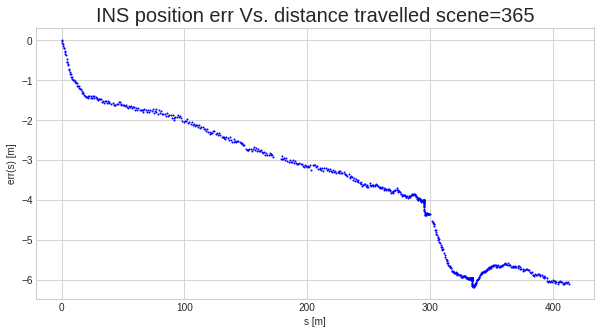

In [131]:
import scipy
scene = 365
dataset = NuscenesDataset(nusc=nusc, directory=directory,scene_id=scene)
N = 800
gt = np.zeros(N)
imu = np.zeros(N)
gt_pos = np.zeros((N,2))
imu_pos = np.zeros((N,2))
timestamp = np.zeros(N)
for t in range(0,N):
    trns, rot = dataset.getEgoInfo(dataset.first_idx + t, GT=True)
    gt[t] = np.linalg.norm(trns[0:2]-gt_pos[t-1, :]) if t > 0 else 0
    gt_pos[t, :] = trns[0:2]
    trns1, rot1 = dataset.getEgoInfo(dataset.first_idx + t, GT=False)
    print("gt", trns, "ins", trns1)
    imu[t] = np.linalg.norm(trns1[0:2]-imu_pos[t-1, :]) if t > 0 else 0
    imu_pos[t, :] = trns1[0:2]
    timestamp[t] = dataset.odometry['timestamp']
    
gt_int = np.cumsum(gt)
imu_int = np.cumsum(imu)
    
fig, ax = plt.subplots(1,figsize=(10,5))
ax.set_title(f"INS position err Vs. distance travelled scene={scene}", fontsize=20)
ax.set(xlabel='s [m]', ylabel='err(s) [m]')
ax.scatter(gt_int,gt_int-imu_int,color='blue',s=1)

scene_id=365 scene_name=scene-0451 map_name=boston-seaport
odom_speed [[1.53728725e+15 1.20000000e+01]
 [1.53728725e+15 1.20000000e+01]
 [1.53728725e+15 1.30000000e+01]
 ...
 [1.53728977e+15 2.60000000e+01]
 [1.53728977e+15 2.60000000e+01]
 [1.53728977e+15 2.60000000e+01]]


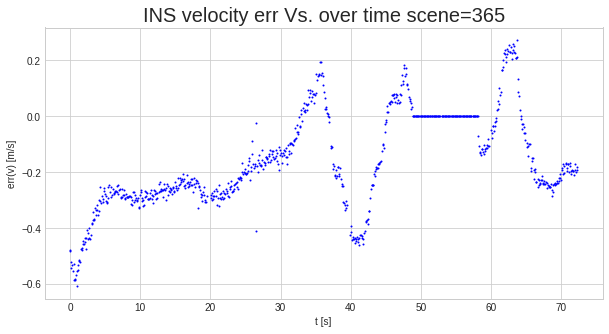

In [134]:
#draw the speed
import scipy
scene = 365
dataset = NuscenesDataset(nusc=nusc, directory=directory,scene_id=scene)
N = 800#800
gt_speed = np.zeros(N)
imu_speed = np.zeros(N)
timestamp = np.zeros(N)
for t in range(0,N):
    trns, rot = dataset.getEgoInfo(dataset.first_idx + t, GT=True)
    gt_speed[t] = np.linalg.norm(dataset.odometry['speed'])
    trns1, rot1 = dataset.getEgoInfo(dataset.first_idx + t, GT=False)
    imu_speed[t] = dataset.odometry['speed']
    timestamp[t] = dataset.odometry['timestamp']
    
fig, ax = plt.subplots(1,figsize=(10,5))
ax.set_title(f"INS velocity err Vs. over time scene={scene}", fontsize=20)
ax.set(xlabel='t [s]', ylabel='err(v) [m/s]')
ax.scatter(timestamp[:]-timestamp[0],gt_speed-imu_speed,color='blue',s=1)

In [ ]:
from pyquaternion import Quaternion

Quaternion.Inverse()

In [ ]:
dataset = NuscenesDataset(nusc=nusc, directory=directory, scene_id=426)
_, _, _, video_data, nusc_map = dataset.getData(700)
map_matching = MapMatching(N=10)

In [ ]:
edges1 = map_matching.getRoadBorders(nuscMap=nusc_map, worldRef=video_data['pos'], layer_names=['walkway'],blur_area=(3,3),threshold1=0.5, threshold2=0.9)
edges2 = map_matching.getRoadBorders(nuscMap=nusc_map, worldRef=video_data['pos'], layer_names=['drivable_area'],blur_area=(3,3),threshold1=0.5, threshold2=0.9)
edges = edges1 & edges2

#road = map_matching.getDrivableArea(nuscMap=nusc_map, worldRef=[400,850],layer_names = ['drivable_area'], patch_size=200)
plt.imshow(edges2, origin='lower')

In [ ]:
a = np.array([[1, 2],[3,4],[5,6],[7,8]])
print(a.shape)
b = np.array([[11, 19],[7,28],[15,16]]).T
print(b.shape)
print(a[:,0].shape)
k = a[:,0].reshape(-1,1)-b[0,:].reshape(1,-1)
t = a[:,1].reshape(-1,1)-b[1,:].reshape(1,-1)
norm = np.sqrt(k**2 + t**2)
it = norm.argmin(axis=1)
print("it", it, "norm",norm)
#print(np.amin(norm, axis=1))
print(k.shape, t.shape)
print(k)
print(np.take_along_axis(k, np.expand_dims(it, axis=-1), axis=1))
print(np.take_along_axis(t, np.expand_dims(it, axis=-1), axis=1))

In [30]:
A = np.zeros((3,3))
pnts = [[0,1],[3,3],[6,1]]
dist = np.array([pnt[0]**2 for pnt in pnts])
candidates = np.where(dist>5)[0]
non_candidates = np.where(dist<=5)[0]

A[candidates,0] = 1
print(A)

[[0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
